In [1]:
# %pip install nipype

In [2]:
# !pip install dcm2niix

In [1]:
import os
import pydicom
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

In [5]:
def load_dicoms_manually(dicom_dir):
    dicom_files = sorted(Path(dicom_dir).glob('*.dcm'))

    if not dicom_files:
        raise Exception(f"No DICOM files found in {dicom_dir}")

    print(f"Found {len(dicom_files)} DICOM files")

    # Load all files and sort by instance number
    volume_slices = []
    orientations = []

    for dcm_path in dicom_files:
        dcm = pydicom.dcmread(str(dcm_path))
        volume_slices.append((dcm.InstanceNumber, dcm.pixel_array))
        orientations.append(dcm.ImageOrientationPatient)  # Store orientation info

    # Sort by instance number
    volume_slices.sort(key=lambda x: x[0])

    # Stack into 3D volume
    volume = np.stack([slice_data for _, slice_data in volume_slices])

    print(f"Successfully created 3D volume of shape {volume.shape}")

    # Check if all orientations are the same
    if len(set(tuple(o) for o in orientations)) > 1:
        print("Warning: Slices have different orientations!")

    return volume

In [6]:
def visualize_slices(volume, num_slices=5):
    # Select evenly spaced slices
    indices = np.linspace(0, volume.shape[1]-1, num_slices, dtype=int)

    plt.figure(figsize=(15, 3))
    for i, idx in enumerate(indices):
        plt.subplot(1, num_slices, i+1)
        plt.imshow(volume[idx], cmap='gray')
        plt.title(f'Slice {idx}')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

In [7]:
dicom_path = "../mri-images/024_S_4169/MPRAGE_GRAPPA2/2012-10-24_14_55_41.0/I342015"

In [8]:
def extract_relevant_slices(brain_volume, start_percent = 25, end_percent = 75):
    """
    Extract relevant slices containing key structures for AD detection
    Parameters:
        brain_volume: 3D numpy array of the full brain volume
        start_percent: starting percentage of volume to include
        end_percent: ending percentage of volume to include
    """
    # total_slices = brain_volume.shape[1]  
    # sagital: total_slices = brain_volume.shape[0]
    total_slices = brain_volume.shape[0]

    # Calculate slice indices
    start_idx = int(total_slices * (start_percent/100))
    end_idx = int(total_slices * (end_percent/100))

    # Extract middle slices (containing relevant structures)
    # relevant_slices = brain_volume[:, start_idx:end_idx, :]  
    # sagital: relevant_slices = brain_volume[start_idx: end_idx]
    relevant_slices = brain_volume[start_idx: end_idx]

    print(f"Total slices: {total_slices}")
    print(f"Selected slices: {end_idx - start_idx} (from {start_idx} to {end_idx})")

    return relevant_slices

In [9]:
def preprocess_slices(slices, target_size = (224, 224)):
    """
    Preprocess the selected slices for CNN input
    """
    import cv2

    processed_slices = []
    for slice_img in slices:
        # Normalize slice
        slice_normalized = (slice_img - slice_img.min()) / (slice_img.max() - slice_img.min())

        # Resize to target size
        slice_resized = cv2.resize(slice_normalized, target_size)

        # Enhance contrast using CLAHE (Contrast Limited Adaptive Histogram Equalization)
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
        slice_enhanced = clahe.apply((slice_resized * 255).astype(np.uint8))

        processed_slices.append(slice_enhanced)

    return np.array(processed_slices)

Number of DICOM files found: 176
Found 176 DICOM files
Successfully created 3D volume of shape (176, 256, 240)

Volume Information:
Shape: (176, 256, 240)
Data type: uint16
Value range: 0 to 1433
Total slices: 176
Selected slices: 88 (from 44 to 132)

Visualizing processed slices...


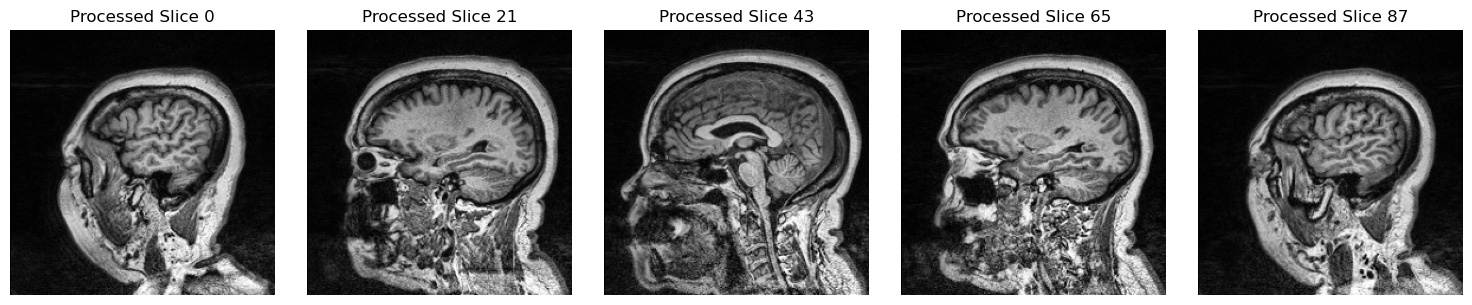


Saved processed slices to processed_ad_slices
Final processed slices shape: (88, 224, 224)


In [ ]:
# Extract and process relevant slices
try:
    # First check if directory exists and contains DICOM files
    if not os.path.exists(dicom_path):
        raise Exception(f"Directory does not exist: {dicom_path}")

    dcm_files = list(Path(dicom_path).glob('*.dcm'))
    print(f"Number of DICOM files found: {len(dcm_files)}")

    # Process the files
    brain_volume = load_dicoms_manually(dicom_path)

    # Basic information about the loaded volume
    print("\nVolume Information:")
    print(f"Shape: {brain_volume.shape}")
    print(f"Data type: {brain_volume.dtype}")
    print(f"Value range: {brain_volume.min()} to {brain_volume.max()}")

    # Normalize the volume
    brain_volume_normalized = (brain_volume - brain_volume.min()) / (brain_volume.max() - brain_volume.min())

    relevant_slices = extract_relevant_slices(brain_volume_normalized)

    # Preprocess slices
    processed_slices = preprocess_slices(relevant_slices)

    # Visualize some processed slices
    def visualize_processed_slices(slices, num_samples = 5):
        indices = np.linspace(0, len(slices)-1, num_samples, dtype=int)

        plt.figure(figsize=(15, 3))
        for i, idx in enumerate(indices):
            plt.subplot(1, num_samples, i+1)
            plt.imshow(slices[idx], cmap='gray')
            plt.title(f'Processed Slice {idx}')
            plt.axis('off')
        plt.tight_layout()
        plt.show()

    print("\nVisualizing processed slices...")
    visualize_processed_slices(processed_slices)

    # Save processed slices
    output_dir = "processed_ad_slices"
    os.makedirs(output_dir, exist_ok = True)
    np.save(os.path.join(output_dir, "ad_relevant_slices.npy"), processed_slices)
    print(f"\nSaved processed slices to {output_dir}")

    # Print final shape
    print(f"Final processed slices shape: {processed_slices.shape}")

except Exception as e:
    print(f"Error during processing: {str(e)}")

In [11]:
sample_processed_img  = np.load("./processed_ad_slices/ad_relevant_slices.npy")
sample_processed_img.shape

(88, 224, 224)

In [12]:
import matplotlib.pyplot as plt

def visualize_slice(volume, slice_index):
    plt.imshow(volume[slice_index], cmap='gray')
    plt.title(f'Slice {slice_index}')
    plt.axis('off')
    plt.show()

# Usage
volume = load_dicoms_manually(dicom_path)
 # Adjust the index as needed

Found 176 DICOM files
Successfully created 3D volume of shape (176, 256, 240)


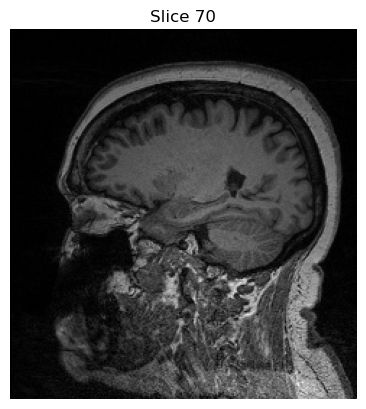

In [13]:
visualize_slice(volume, slice_index = 70)

In [ ]:
# Function to visualize processed slices
def visualize_processed_slices(slices, num_samples=5):
    indices = np.linspace(0, len(slices)-1, num_samples, dtype=int)

    plt.figure(figsize=(15, 3))
    for i, idx in enumerate(indices):
        plt.subplot(1, num_samples, i+1)
        plt.imshow(slices[idx], cmap='gray')
        plt.title(f'Processed Slice {idx}')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Define root directory where all patient data is stored
root_dir = "../mri-images"

# List of folder names to check for modality
modality_folders = ["MPRAGE", "MP-RAGE", "MP-RAGE_REPEAT", "MPRAGE_SENSE2", "Sagittal_3D_FLAIR"]

# Loop through each patient folder
for patient_id in os.listdir(root_dir):
    patient_path = os.path.join(root_dir, patient_id)

    # Check if the current path is a directory (i.e., a patient folder)
    if not os.path.isdir(patient_path):
        continue

    print(f"Processing patient: {patient_id}")

    # Find the correct modality folder
    modality_folder = None
    for folder_name in modality_folders:
        modality_path = os.path.join(patient_path, folder_name)
        if os.path.exists(modality_path):
            modality_folder = modality_path
            break

    if modality_folder is None:
        print(f"Error: No valid modality folder found for patient {patient_id}. Skipping...")
        continue

    # Loop through all date folders within the modality folder
    for date_folder in os.listdir(modality_folder):
        date_path = os.path.join(modality_folder, date_folder)

        # Check if the current path is a directory (i.e., a date folder)
        if not os.path.isdir(date_path):
            continue

        print(f"Processing date: {date_folder}")

        # Loop through all files in the date folder
        for scan_file in os.listdir(date_path):
            scan_path = os.path.join(date_path, scan_file)
            print(f"Processing scan: {scan_path}")
            # if not os.path.isfile(scan_path):
            #     print(f"Error: {scan_path} is not a file. Skipping...")
            #     continue

            try:
                # Load the brain volume from the scan file (assumed to be a DICOM or similar)
                brain_volume = load_dicoms_manually(scan_path)  # Define how to load the DICOM or NIfTI

                # Extract and preprocess slices
                relevant_slices = extract_relevant_slices(brain_volume)
                processed_slices = preprocess_slices(relevant_slices)

                # Visualize some processed slices
                print(f"Visualizing processed slices for patient {patient_id}, date {date_folder}...")
                visualize_processed_slices(processed_slices)

                # Save processed slices
                output_dir = os.path.join("../colab_preprocessed", patient_id, date_folder)
                os.makedirs(output_dir, exist_ok=True)
                np.save(os.path.join(output_dir, "ad_relevant_slices.npy"), processed_slices)
                print(f"Saved processed slices for {patient_id} on {date_folder} to {output_dir}")

                # Print final shape of the processed slices
                print(f"Final processed slices shape: {processed_slices.shape}")

            except Exception as e:
                print(f"Error processing {scan_file} for patient {patient_id}, date {date_folder}: {str(e)}")
                continue